In [3]:
import os
username = #your eagle username here
password = #your eagle password here
os.environ['EAGLE_USERNAME'] = username
os.environ['EAGLE_PASSWORD'] = password
os.environ['EAGLE_BASE_PATH'] = '/hpcdata6/astrcrai/backup' #this should point at your local EAGLE simulations
os.environ['EAGLE_ACCESS_TYPE'] = 'ARI'
import eaglepy.database as database
import eaglepy.h5read as h5read
import numpy as np
import matplotlib.pyplot as plt
import eagleSqlTools as sql
import tqdm
import h5py
from scipy.integrate import quad
from astropy.io import ascii
import iso_pop
#cosmology 
Omega0, OmegaLambda, a_0, h = 0.307, 0.693, 1., 0.6777
plt.style.use('nature') #comment this put if you dont have the plot style!


def t_lookback(a):
    return a / (np.sqrt(Omega0 * a + OmegaLambda * (a ** 4)))

t_em = quad(t_lookback, 0., a_0)[0]
t_em = (1 / (h * 100)) * (3.086e19 / 3.1536e16) * t_em

def z2age(z):
    a = 1 / (1 + z)
    t = np.array([quad(t_lookback, x, a_0)[0] for x in a])
    return (1 / (h * 100)) * (3.086e19 / 3.1536e16) * t

def a2age(a):
    t = np.array([quad(t_lookback, x, a_0)[0] for x in a])
    return (1 / (h * 100)) * (3.086e19 / 3.1536e16) * t

def z2tau(z):
    a = 1 / (1 + z)
    t = np.array([quad(t_lookback, x, a_0)[0] for x in a])
    return t_em - ((1 / (h * 100)) * (3.086e19 / 3.1536e16) * t)

def t_con(dens, m_g=1.8e6):
    mu = 1.22
    m_p = 1.6726e-24
    T_0 = 8e3
    xH = 0.752
    rho_0 = 0.1 * m_p / xH
    P_0_on_kb = rho_0*T_0/mu/m_p
    P_eos_on_kb = P_0_on_kb*((dens*6.77e-31)/rho_0)**(4./3.)
    P_eos = P_eos_on_kb*1.38e-16
    G = 6.67e-8 #cgs
    A = 1.515e-4 / 1e6
    nhs = dens2nh(dens)
    ns = np.zeros(len(dens))
    t_g = 1.67e9*(P_eos_on_kb/10**3)**-0.2 #schaye and dalla vecchia 08 approximation
    return t_g, P_eos

def dens2nh(dens):
    tdens = (0.752/1.6726e-24)*(dens*6.77e-31)
    return tdens

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [4]:

if not os.path.exists('../sav/water_frac_mean_age.npy'):
    run = 'L0100N1504'
    model = 'REFERENCE'
    tag = '028_z000p000'

    subfind = h5read.Subfind(run, model, tag)

    cops = subfind.get_dataset('FOF/GroupCentreOfPotential')
    gnums = subfind.get_dataset('Subhalo/GroupNumber')

    fsids = subfind.get_dataset('FOF/FirstSubhaloID').astype('int')
    mass_30kpc = subfind.get_dataset('Subhalo/ApertureMeasurements/Mass/030kpc', physical=True)[fsids]
    halfmassrad = subfind.get_dataset('Subhalo/HalfMassRad')[fsids]
    subcops = subfind.get_dataset('Subhalo/CentreOfPotential')[fsids]
    subsfr = subfind.get_dataset('Subhalo/ApertureMeasurements/SFR/030kpc', physical=True)[fsids]
    iron = subfind.get_dataset('Subhalo/Stars/ElementAbundance/Iron', physical=True)[fsids]
    hydrogen = subfind.get_dataset('Subhalo/Stars/ElementAbundance/Hydrogen', physical=True)[fsids]
    oxygen = subfind.get_dataset('Subhalo/Stars/ElementAbundance/Oxygen', physical=True)[fsids]

    galaxy_mask = (np.log10(mass_30kpc[:,4]*1e10) > 10.) & (np.log10(mass_30kpc[:,4]*1e10) < 11.)

    water_rich_fracs = np.zeros(len(subcops[galaxy_mask]))
    mean_age = np.zeros(len(subcops[galaxy_mask]))

    for i in tqdm.tqdm_notebook(range(len(subcops[galaxy_mask]))):
        snap = h5read.SnapshotRegion(run, model, tag, subcops[galaxy_mask][i], halfmassrad[:,4][galaxy_mask][i]*2)
        snap.center_and_align(parttype=4, align_percentile=10)
        abundances = snap.abundance_ratios()
        waterfrac = iso_pop.get_iso_water_fraction(abundances['Iron'])
        sftime = snap.get_dataset(4, 'StellarFormationTime', physical=True)
        ages = snap.a2age(sftime)
        water_rich_fracs[i] = sum(waterfrac > 0.4)/len(waterfrac)
        mean_age[i] = np.median(ages)
    with open('../sav/water_frac_mean_age.npy', 'wb') as f:
        np.save(f, water_rich_fracs)
        np.save(f, mean_age)
        np.save(f, iron[galaxy_mask])
        np.save(f, hydrogen[galaxy_mask])
        np.save(f, oxygen[galaxy_mask])
        np.save(f, gnums[fsids][galaxy_mask])
        np.save(f, mass_30kpc[galaxy_mask])
else:
    with open('../sav/water_frac_mean_age.npy', 'rb') as f:
        water_rich_fracs = np.load(f) 
        mean_age = np.load(f) 
        iron = np.load(f) 
        hydrogen = np.load(f) 
        oxygen = np.load(f) 
        gnums = np.load(f) 
        mass_30kpc = np.load(f) 


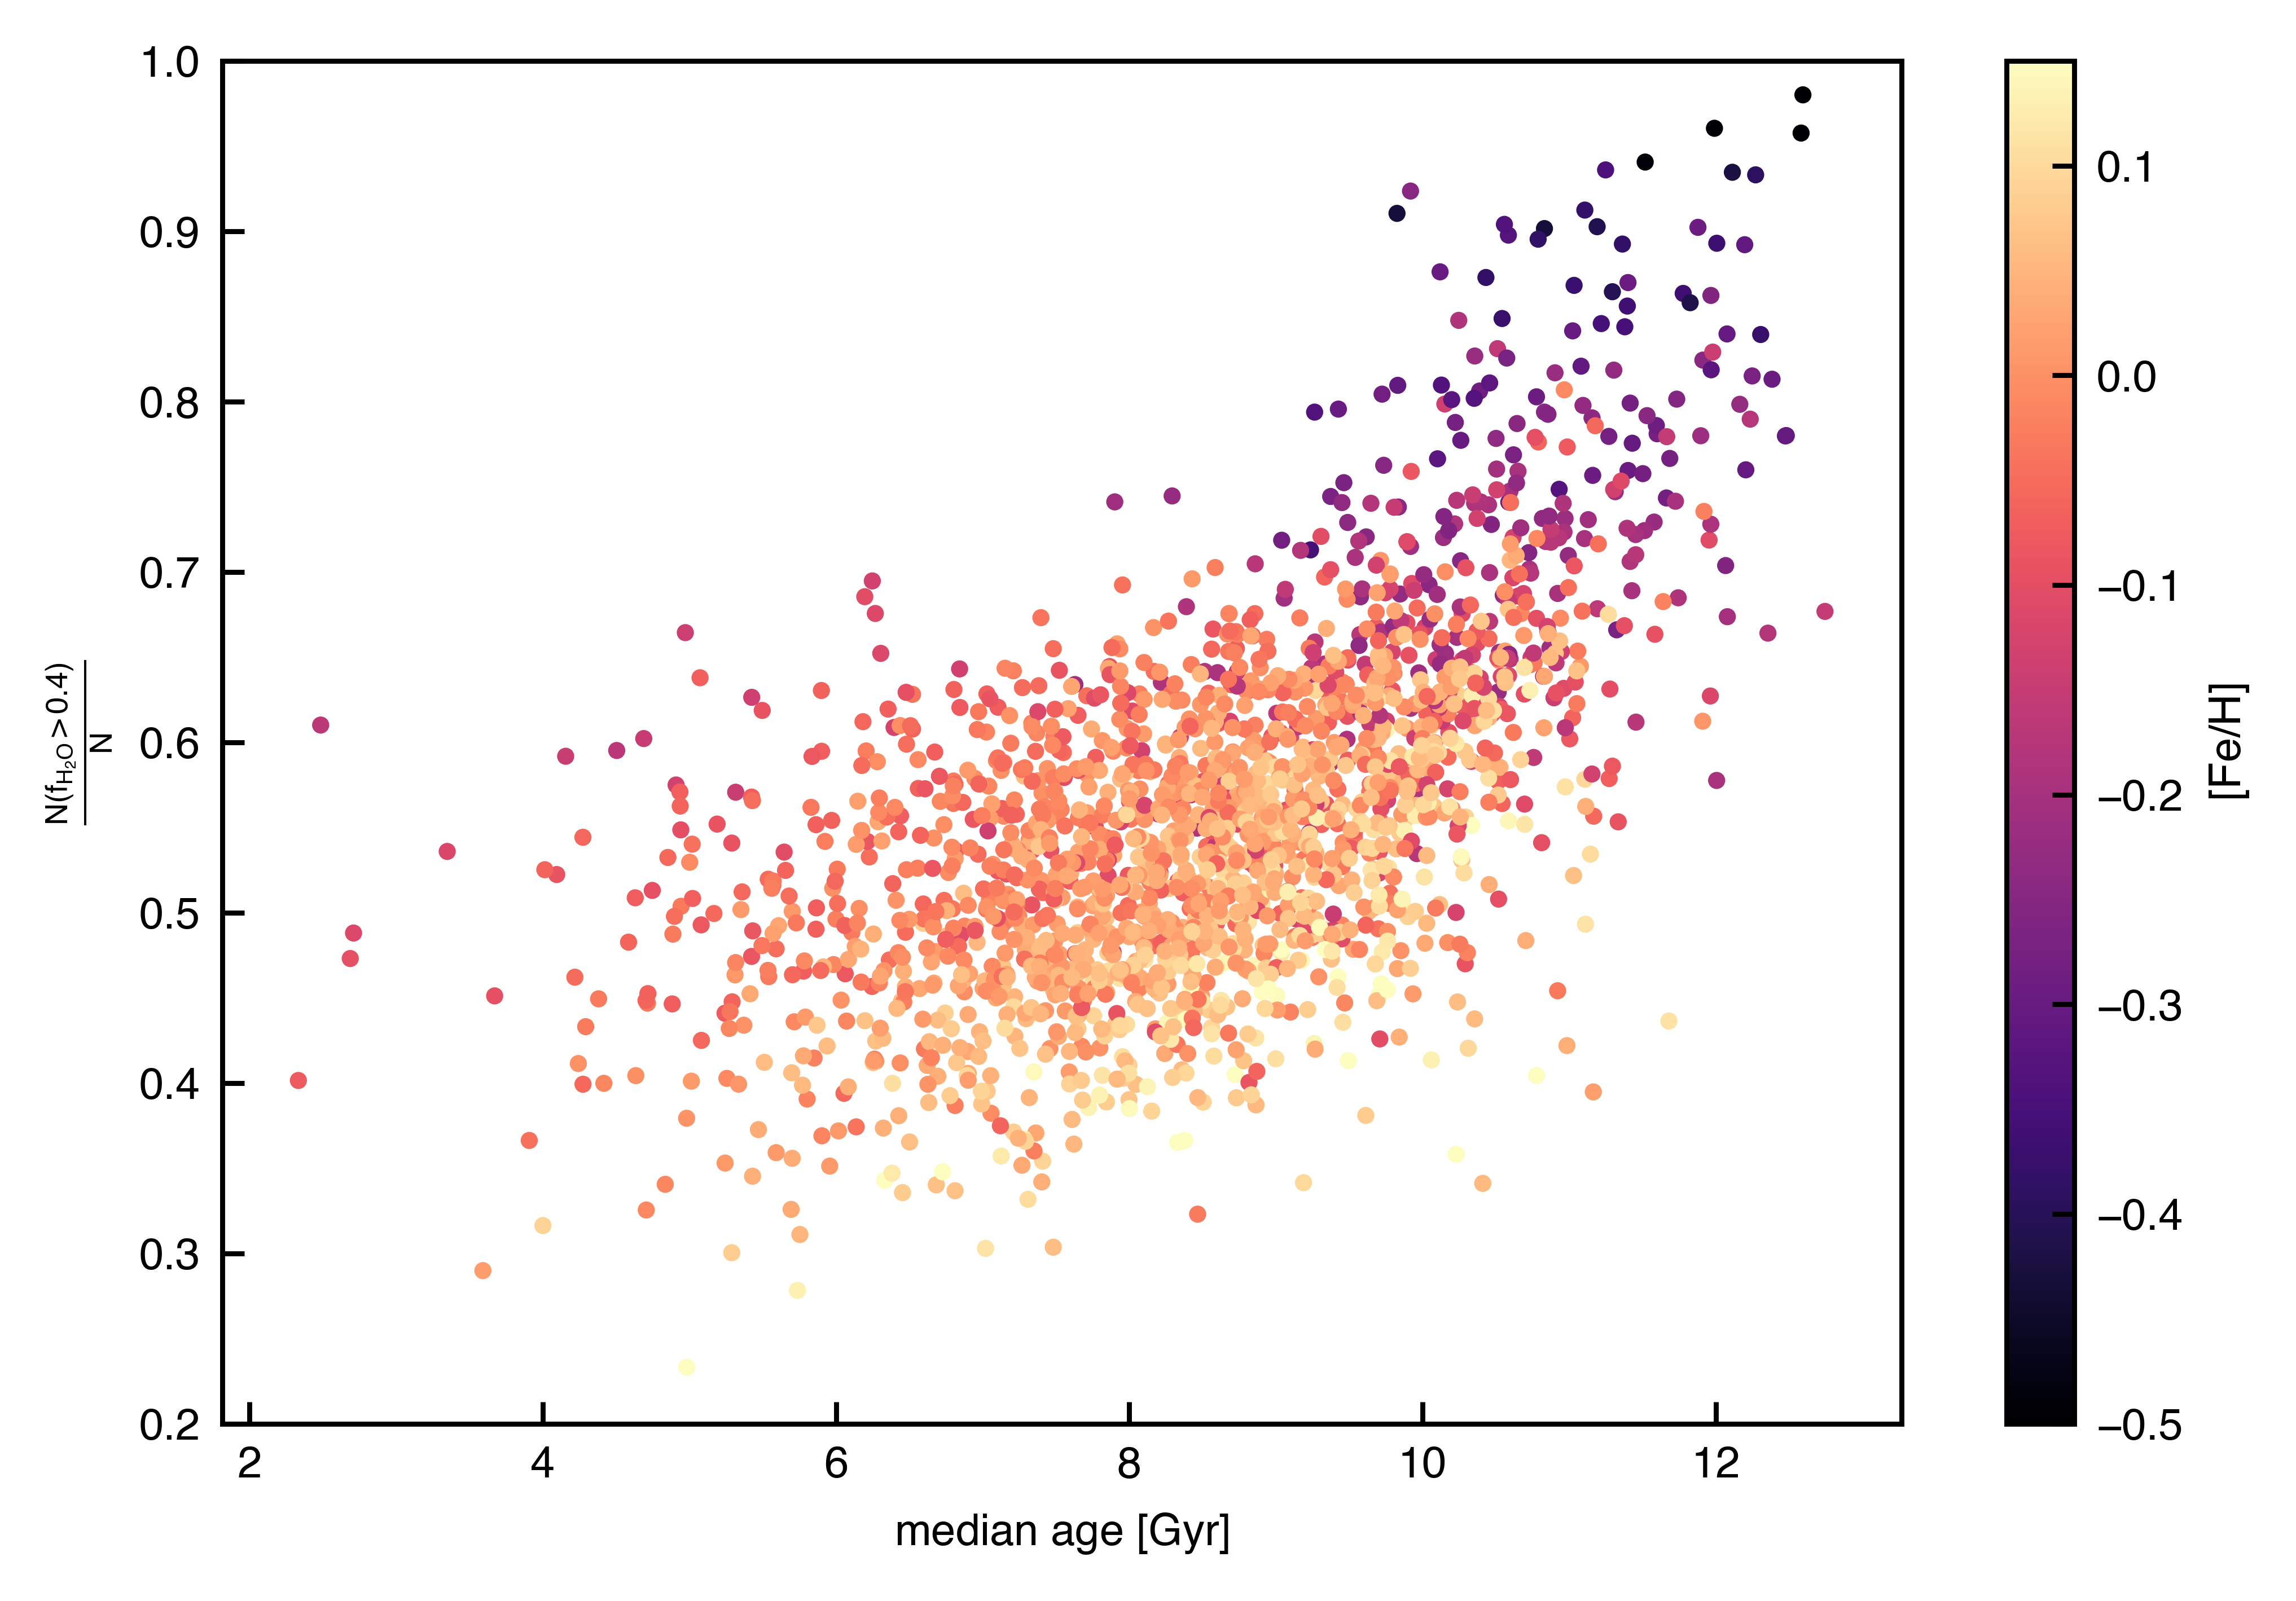

In [7]:
solar_H = 0.706498
solar_Fe = 0.00110322
solar_O = 0.00549262
solar_Si = 0.000682587
solar_Mg = 0.000590706
solar_Ca = 6.4355e-05

fig = plt.figure()
fig.set_size_inches(6,4)
plt.scatter(mean_age, water_rich_fracs, s=3, c=np.log10(iron/hydrogen)-np.log10(solar_Fe/solar_H), cmap=plt.cm.magma, rasterized=True, vmin=-0.5, vmax=0.15)
plt.colorbar(label=r'$\mathrm{[Fe/H]}$')

plt.xlabel(r'$\mathrm{median\ age\ [Gyr]}$')
plt.ylabel(r'$\frac{N(f_{\mathrm{H_2O}} > 0.4)}{N}$')

plt.ylim(0.2,1.)
plt.savefig('../plots/water_rich_frac_vs_median_age.pdf', format='pdf', dpi=400, bbox_inches='tight')